El primer proyecto será una <u>predicción de ventas</u> para productos alimenticios que se venden en distintas tiendas. El objetivo es ayudar a la tienda a comprender las <u>propiedades de los productos</u> y <u>establecimientos que tienen un rol crucial en aumentar las ventas</u>.



# Descarga, Exploracion y limpieza de datos

In [334]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [412]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [336]:
sp_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data_para_Panda_CienciaDeDatos/sales_predictions.csv')
sp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Aqui veo que tengo dos columnas con valores faltantes:
* Item_Weight
* Outlet_Size

In [337]:
sp_df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


Aqui veo que:
* Item_Visibility puede tener valores outliers, calculando sus cuartiles el valor max deberia ser alrededor de 0.17.
* Item_Visibility tambien tiene valores en 0, considerando que es la visibilidad del producto, son items que no serán adquiridos facilmente por el cliente.
* Item_Outlet_Sales tiene valores outliers, calculando sus cuartiles el valor max deberia ser alrededor de 5,300. La disparidad puede deberse al caso anterior, de que hay productos que no tienen visibilidad.

## Analizando Columna Item_Weight

In [338]:
sp_df_wna = sp_df[sp_df['Item_Weight'].isna()]
sp_df_wna

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
21,FDW12,NaN,Regular,0.035400,Baking Goods,144.5444,OUT027,1985,Medium,Tier 3,Supermarket Type3,4064.0432
23,FDC37,NaN,Low Fat,0.057557,Baking Goods,107.6938,OUT019,1985,Small,Tier 1,Grocery Store,214.3876
29,FDC14,NaN,Regular,0.072222,Canned,43.6454,OUT019,1985,Small,Tier 1,Grocery Store,125.8362
...,...,...,...,...,...,...,...,...,...,...,...,...
8485,DRK37,NaN,Low Fat,0.043792,Soft Drinks,189.0530,OUT027,1985,Medium,Tier 3,Supermarket Type3,6261.8490
8487,DRG13,NaN,Low Fat,0.037006,Soft Drinks,164.7526,OUT027,1985,Medium,Tier 3,Supermarket Type3,4111.3150
8488,NCN14,NaN,Low Fat,0.091473,Others,184.6608,OUT027,1985,Medium,Tier 3,Supermarket Type3,2756.4120
8490,FDU44,NaN,Regular,0.102296,Fruits and Vegetables,162.3552,OUT019,1985,Small,Tier 1,Grocery Store,487.3656


Tengo 1463 registros de productos, sin peso.

In [339]:
sp_df_wna['Item_Identifier'].value_counts().sort_index()

Item_Identifier
DRA24    2
DRA59    2
DRB01    1
DRB25    1
DRB48    1
        ..
NCZ17    1
NCZ18    1
NCZ30    1
NCZ53    1
NCZ54    2
Name: count, Length: 1142, dtype: int64

In [340]:
sp_df_w = sp_df[sp_df['Item_Weight'].notna()]
sp_df_w

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


Tengo 7060 registros de productos con peso, me puede servir asociar el Item_identifier a un peso único y asi completar los valores nulos de la columna Item_Weight.

In [341]:
sp_df_w['Item_Identifier'].value_counts().sort_index()

Item_Identifier
DRA12    6
DRA24    5
DRA59    6
DRB01    2
DRB13    5
        ..
NCZ30    6
NCZ41    5
NCZ42    5
NCZ53    4
NCZ54    5
Name: count, Length: 1555, dtype: int64

Reviso cuantos codigos de producto tengo, hay 1555 valores unicos de 1559 que tiene la base principal, eso quiere decir que habra 4 sin poder reemplazar con la relacion codigo producto - peso.

In [342]:
base_IDproducto_peso = sp_df_w[['Item_Identifier', 'Item_Weight']].drop_duplicates()
base_IDproducto_peso.sort_index()

,Item_Identifier,Item_Weight
0,FDA15,9.300
1,DRC01,5.920
2,FDN15,17.500
3,FDX07,19.200
4,NCD19,8.930
...,...,...
7298,NCW05,20.250
7373,FDS09,8.895
7421,FDU43,19.350
7944,FDO49,10.600


In [343]:
sp_df[['Item_Identifier', 'Item_Weight']].drop_duplicates()

,Item_Identifier,Item_Weight
0,FDA15,9.30
1,DRC01,5.92
2,FDN15,17.50
3,FDX07,19.20
4,NCD19,8.93
...,...,...
8471,NCT53,5.40
8472,NCS41,NaN
8480,FDQ58,NaN
8487,DRG13,NaN


In [344]:
base_IDproducto_peso['Item_Identifier'].duplicated().sum()

0

Ahora creo un diccionario con los codigos de producto y peso, esto me sirve para reemplazar los valores faltantes.

In [345]:
dic_peso = base_IDproducto_peso.set_index('Item_Identifier')['Item_Weight'].to_dict()
dic_peso

{'FDA15': 9.3,
 'DRC01': 5.92,
 'FDN15': 17.5,
 'FDX07': 19.2,
 'NCD19': 8.93,
 'FDP36': 10.395,
 'FDO10': 13.65,
 'FDH17': 16.2,
 'FDU28': 19.2,
 'FDY07': 11.8,
 'FDA03': 18.5,
 'FDX32': 15.1,
 'FDS46': 17.6,
 'FDF32': 16.35,
 'FDP49': 9.0,
 'NCB42': 11.8,
 'FDU02': 13.35,
 'FDN22': 18.85,
 'NCB30': 14.6,
 'FDR28': 13.85,
 'NCD06': 13.0,
 'FDV10': 7.645,
 'DRJ59': 11.65,
 'FDE51': 5.925,
 'FDV38': 19.25,
 'NCS17': 18.6,
 'FDP33': 18.7,
 'FDO23': 17.85,
 'DRH01': 17.5,
 'NCX29': 10.0,
 'DRZ11': 8.85,
 'FDK43': 9.8,
 'FDA46': 13.6,
 'FDC02': 21.35,
 'FDL50': 12.15,
 'FDM39': 6.42,
 'NCP05': 19.6,
 'FDV49': 10.0,
 'FDL12': 15.85,
 'NCL17': 7.39,
 'FDM40': 10.195,
 'FDR13': 9.895,
 'FDA43': 10.895,
 'NCP18': 12.15,
 'FDK21': 7.905,
 'NCX54': 9.195,
 'DRK35': 8.365,
 'FDY21': 15.1,
 'FDM20': 10.0,
 'FDV27': 7.97,
 'FDC46': 17.7,
 'FDH19': 19.35,
 'FDZ03': 13.65,
 'DRH37': 17.6,
 'NCI17': 8.645,
 'FDJ58': 15.6,
 'FDH35': 18.25,
 'FDG02': 7.855,
 'NCZ18': 7.825,
 'FDC29': 8.39,
 'FDQ10': 12.

In [346]:
len(dic_peso)

1555

In [347]:
sp_df.loc[sp_df['Item_Weight'].isna(), 'Item_Weight'] = sp_df.loc[sp_df['Item_Weight'].isna(), 'Item_Identifier'].map(dic_peso)

Compruebo para ver los 4 productos que no tienen peso:

In [348]:
sp_df[sp_df['Item_Weight'].isna()]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
927,FDN52,NaN,Regular,0.130933,Frozen Foods,86.9198,OUT027,1985,Medium,Tier 3,Supermarket Type3,1569.9564
1922,FDK57,NaN,Low Fat,0.079904,Snack Foods,120.0440,OUT027,1985,Medium,Tier 3,Supermarket Type3,4434.2280
4187,FDE52,NaN,Regular,0.029742,Dairy,88.9514,OUT027,1985,Medium,Tier 3,Supermarket Type3,3453.5046
5022,FDQ60,NaN,Regular,0.191501,Baking Goods,121.2098,OUT019,1985,Small,Tier 1,Grocery Store,120.5098


Veo que los productos tienen un correlativo, es posible que ordenando el codigo de producto se pueda ver alguna relacion con el peso.

In [349]:
filtro1 = sp_df[sp_df['Item_Identifier'].str.startswith('FDN')].sort_values(by='Item_Identifier')
filtro1[['Item_Identifier',	'Item_Weight']].drop_duplicates()

,Item_Identifier,Item_Weight
3683,FDN01,8.895
852,FDN02,16.500
6912,FDN03,9.800
2729,FDN04,11.800
3945,FDN08,7.720
1953,FDN09,14.150
2666,FDN10,11.500
3086,FDN12,15.600
3767,FDN13,18.600
4817,FDN15,17.500


Como no hay una relacion veamos si ha nivel de tienda y tipo de producto, hay alguna relacion en cuanto al peso.

In [350]:
filtro2 = sp_df[(sp_df['Item_Identifier'].str.startswith('FDN')) & (sp_df['Item_Type']=='Frozen Foods') & (sp_df['Outlet_Identifier']=='OUT027')]
filtro2[['Item_Identifier',	'Item_Weight']].drop_duplicates()

,Item_Identifier,Item_Weight
927,FDN52,NaN
1142,FDN04,11.8


Tiene muy pocos valores para inferir, por tanto vamos a usar la media agrupada por tipo de producto y codigo para completar tanto este valor como el resto de los productos.

In [351]:
FDN_df = sp_df[(sp_df['Item_Identifier'].str.startswith('FDN')) & (sp_df['Item_Type']=='Frozen Foods')]
media_FDN = FDN_df['Item_Weight'].mean()
print('El valor para FDN52 será de', round(media_FDN,2))

El valor para FDN52 será de 9.45


In [352]:
FDK_df = sp_df[(sp_df['Item_Identifier'].str.startswith('FDK')) & (sp_df['Item_Type']=='Snack Foods')]
media_FDK = FDK_df['Item_Weight'].mean()
print('El valor para FDK57 será de', round(media_FDK,2))

El valor para FDK57 será de 11.55


In [353]:
FDE_df = sp_df[(sp_df['Item_Identifier'].str.startswith('FDE')) & (sp_df['Item_Type']=='Dairy')]
media_FDE = FDE_df['Item_Weight'].mean()
print('El valor para FDE52 será de', round(media_FDE,2))

El valor para FDE52 será de 9.66


In [354]:
FDQ_df = sp_df[(sp_df['Item_Identifier'].str.startswith('FDQ')) & (sp_df['Item_Type']=='Baking Goods')]
media_FDQ = FDQ_df['Item_Weight'].mean()
print('El valor para FDQ60 será de', round(media_FDQ,2))

El valor para FDQ60 será de 12.28


In [355]:
dic_peso_2 = { 'FDN52' : 9.45,
               'FDK57' : 11.55,
               'FDE52' : 9.66,
               'FDQ60' : 12.28 }

sp_df.loc[sp_df['Item_Weight'].isna(), 'Item_Weight'] = sp_df.loc[sp_df['Item_Weight'].isna(), 'Item_Identifier'].map(dic_peso_2)

In [356]:
sp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Ya tengo todos los valores reemplazados. Convierto la columna Item_Weight a float.

In [357]:
sp_df['Item_Weight'].astype('float')

0        9.300
1        5.920
2       17.500
3       19.200
4        8.930
         ...  
8518     6.865
8519     8.380
8520    10.600
8521     7.210
8522    14.800
Name: Item_Weight, Length: 8523, dtype: float64

In [358]:
sp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


## Analizando Columna Outlet_Size

In [359]:
sp_df_sna = sp_df[sp_df['Outlet_Size'].isna()]
sp_df_sna

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350
25,NCD06,13.000,Low Fat,0.099887,Household,45.9060,OUT017,2007,NaN,Tier 2,Supermarket Type1,838.9080
28,FDE51,5.925,Regular,0.161467,Dairy,45.5086,OUT010,1998,NaN,Tier 3,Grocery Store,178.4344
...,...,...,...,...,...,...,...,...,...,...,...,...
8502,NCH43,8.420,Low Fat,0.070712,Household,216.4192,OUT045,2002,NaN,Tier 2,Supermarket Type1,3020.0688
8508,FDW31,11.350,Regular,0.043246,Fruits and Vegetables,199.4742,OUT045,2002,NaN,Tier 2,Supermarket Type1,2587.9646
8509,FDG45,8.100,Low Fat,0.214306,Fruits and Vegetables,213.9902,OUT010,1998,NaN,Tier 3,Grocery Store,424.7804
8514,FDA01,15.000,Regular,0.054489,Canned,57.5904,OUT045,2002,NaN,Tier 2,Supermarket Type1,468.7232


Tengo 240 registros de tamaño, con valores nulos. Revisemos cuales son los Outlet que no tienen tamaño y si tenemos alguna otra data de los mismos.

In [360]:
sp_df_sna.groupby('Outlet_Identifier')['Outlet_Size'].unique()

Outlet_Identifier
OUT010    [nan]
OUT017    [nan]
OUT045    [nan]
Name: Outlet_Size, dtype: object

In [361]:
sp_df.groupby('Outlet_Identifier')['Outlet_Size'].unique()

Outlet_Identifier
OUT010       [nan]
OUT013      [High]
OUT017       [nan]
OUT018    [Medium]
OUT019     [Small]
OUT027    [Medium]
OUT035     [Small]
OUT045       [nan]
OUT046     [Small]
OUT049    [Medium]
Name: Outlet_Size, dtype: object

No hay información para esos outlets en otros registros.

In [362]:
sp_df.groupby(['Outlet_Identifier','Outlet_Size'])['Item_Outlet_Sales'].sum()/1000

Outlet_Identifier  Outlet_Size
OUT013             High           2142.663578
OUT018             Medium         1851.822830
OUT019             Small           179.694094
OUT027             Medium         3453.926051
OUT035             Small          2268.122935
OUT046             Small          2118.395168
OUT049             Medium         2183.969810
Name: Item_Outlet_Sales, dtype: float64

No hay un relacion entre el Size y las ventas totales por establecimiento.

In [363]:
sp_df.groupby('Outlet_Location_Type')['Outlet_Size'].unique()

Outlet_Location_Type
Tier 1        [Medium, Small]
Tier 2           [nan, Small]
Tier 3    [Medium, nan, High]
Name: Outlet_Size, dtype: object

El tipo de locación también es variado.


In [364]:
sp_df.groupby('Outlet_Type')['Outlet_Size'].unique()

Outlet_Type
Grocery Store                      [nan, Small]
Supermarket Type1    [Medium, High, nan, Small]
Supermarket Type2                      [Medium]
Supermarket Type3                      [Medium]
Name: Outlet_Size, dtype: object

Podemos determinar que una Grocery Store siempre sera Small, ademas es la moda dentro de esa categoría, por tanto consideraremos:
* OUT010 igual a Small.

In [365]:
grocery_small = sp_df[sp_df['Outlet_Identifier'] == 'OUT010']
grocery_small['Outlet_Size'].fillna('Small', inplace=True)
sp_df.update(grocery_small)
sp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6668 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


<ipython-input-365-4436b57e6cc8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grocery_small['Outlet_Size'].fillna('Small', inplace=True)


Revisemos los otros 2 Outlets:
* OUT017
* OUT045

In [366]:
sp_df.groupby(['Outlet_Location_Type','Outlet_Type',])['Outlet_Size'].unique()

Outlet_Location_Type  Outlet_Type      
Tier 1                Grocery Store                [Small]
                      Supermarket Type1    [Medium, Small]
Tier 2                Supermarket Type1       [nan, Small]
Tier 3                Grocery Store                [Small]
                      Supermarket Type1             [High]
                      Supermarket Type2           [Medium]
                      Supermarket Type3           [Medium]
Name: Outlet_Size, dtype: object

In [367]:
sp_df.groupby(['Outlet_Identifier','Outlet_Size'])['Item_Identifier'].nunique()

Outlet_Identifier  Outlet_Size
OUT010             Small          555
OUT013             High           932
OUT018             Medium         928
OUT019             Small          528
OUT027             Medium         935
OUT035             Small          930
OUT046             Small          930
OUT049             Medium         930
Name: Item_Identifier, dtype: int64

Agrupando tipo de locacion y tipo de Outlet, es probale que el valor faltante para Supermarket Type1 sea Medium, pero para confirmar revisemos la moda.

Por otro lado no hay relación entre el Outlet Size y la cantidad de productos vendidos.


In [368]:
filtro_sup1 = sp_df[sp_df['Outlet_Type'] == 'Supermarket Type1']
filtro_sup1['Outlet_Size'].value_counts()

Outlet_Size
Small     1860
High       932
Medium     930
Name: count, dtype: int64

In [369]:
filtro_sup1.groupby(['Outlet_Location_Type'])['Outlet_Identifier'].unique()

Outlet_Location_Type
Tier 1            [OUT049, OUT046]
Tier 2    [OUT045, OUT017, OUT035]
Tier 3                    [OUT013]
Name: Outlet_Identifier, dtype: object

Revisando el valor que mas repite para Supermarket Type 1 es Small, además según muestra el Tier 2 para Supermarket Type, el outlet OUT035 es Small por tanto consideraremos:

* OUT045 igual a Small.
* OUT017 igual a Small.

In [370]:
filtro_OUT045 = sp_df[sp_df['Outlet_Identifier'] == 'OUT045']
filtro_OUT045['Outlet_Size'].fillna('Small', inplace=True)
sp_df.update(filtro_OUT045)
sp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                7597 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


<ipython-input-370-311d426b40c4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtro_OUT045['Outlet_Size'].fillna('Small', inplace=True)


In [371]:
filtro_OUT017 = sp_df[sp_df['Outlet_Identifier'] == 'OUT017']
filtro_OUT017['Outlet_Size'].fillna('Small', inplace=True)
sp_df.update(filtro_OUT017)
sp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


<ipython-input-371-3f020c2aacb9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtro_OUT017['Outlet_Size'].fillna('Small', inplace=True)


# Resúmenes estadísticos, información agregada, u otras tendencias observarbles


In [372]:
sp_df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.874416,0.066132,140.992782,1997.831867,2181.288914
std,4.645313,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.785000,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


En Item_Visibility hay al menos un producto con valor cero, veamos si tienen ventas.

In [373]:
filtro_visib_cero = sp_df[sp_df['Item_Visibility'] == 0]
filtro_visib_cero

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.200,Regular,0.0,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.0,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.0,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
10,FDY07,11.800,Low Fat,0.0,Fruits and Vegetables,45.5402,OUT049,1999,Medium,Tier 1,Supermarket Type1,1516.0266
32,FDP33,18.700,Low Fat,0.0,Snack Foods,256.6672,OUT018,2009,Medium,Tier 3,Supermarket Type2,3068.0064
...,...,...,...,...,...,...,...,...,...,...,...,...
8480,FDQ58,7.315,Low Fat,0.0,Snack Foods,154.5340,OUT019,1985,Small,Tier 1,Grocery Store,459.4020
8484,DRJ49,6.865,Low Fat,0.0,Soft Drinks,129.9652,OUT013,1987,High,Tier 3,Supermarket Type1,2324.9736
8486,FDR20,20.000,Regular,0.0,Fruits and Vegetables,46.4744,OUT010,1998,Small,Tier 3,Grocery Store,45.2744
8494,NCI54,15.200,Low Fat,0.0,Household,110.4912,OUT017,2007,Small,Tier 2,Supermarket Type1,1637.8680


Revisando vemos que corresponde a 526 registros de los cuales si tenemos ventas, y los registros provienen de dos tiendas OUT010 y OUT049. Podría entenderse que si bien los productos no son visibles los clientes los solicitan a pedido.

In [374]:
filtro_visib_cero.groupby(['Outlet_Identifier', 'Item_Type'])['Item_Outlet_Sales'].sum()

Outlet_Identifier  Item_Type            
OUT010             Breads                     585.2382
                   Canned                     188.4214
                   Frozen Foods               873.5296
                   Fruits and Vegetables     2557.3378
                   Hard Drinks                129.8310
                                               ...    
OUT049             Meat                      1896.1984
                   Others                    1120.5414
                   Snack Foods              12507.7188
                   Soft Drinks               4223.1694
                   Starchy Foods             4296.4074
Name: Item_Outlet_Sales, Length: 132, dtype: float64

In [375]:
sp_df.groupby(['Item_Identifier', 'Outlet_Identifier'])['Item_MRP'].mean().reset_index()

,Item_Identifier,Outlet_Identifier,Item_MRP
0,DRA12,OUT010,143.0154
1,DRA12,OUT013,142.3154
2,DRA12,OUT017,140.3154
3,DRA12,OUT018,142.0154
4,DRA12,OUT035,141.9154
...,...,...,...
8518,NCZ54,OUT019,160.9552
8519,NCZ54,OUT027,164.0552
8520,NCZ54,OUT045,162.4552
8521,NCZ54,OUT046,161.9552


Cada Outlet tiene el poder de modificar el precio de sus productos, sin embargo la variación significativa sólo es entre distintos tipos de productos, dentro de los mismos no es considerable.

In [376]:
sp_df.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].sum()/1000

Outlet_Location_Type
Tier 1    4482.059072
Tier 2    6472.313706
Tier 3    7636.752632
Name: Item_Outlet_Sales, dtype: float64

El grupo de tiendas que mas ventas ha realizado es el Tier 3.

In [377]:
outlets_tier3 = sp_df[sp_df['Outlet_Location_Type'] == 'Tier 3']
outlets_tier3.groupby('Outlet_Identifier')['Item_Outlet_Sales'].sum().sort_values(ascending=False)/1000

Outlet_Identifier
OUT027    3453.926051
OUT013    2142.663578
OUT018    1851.822830
OUT010     188.340172
Name: Item_Outlet_Sales, dtype: float64

Estas son los 4 outlets que realizaron más ventas.

In [378]:
outlets_tier1 = sp_df[sp_df['Outlet_Location_Type'] == 'Tier 1']
outlets_tier1.groupby('Outlet_Identifier')['Item_Outlet_Sales'].sum().sort_values()/1000

Outlet_Identifier
OUT019     179.694094
OUT046    2118.395168
OUT049    2183.969810
Name: Item_Outlet_Sales, dtype: float64

Estas son los 3 outlets que realizaron menos ventas.

In [379]:
sp_df['Cantidades_vendidas'] = sp_df['Item_Outlet_Sales'] / sp_df['Item_MRP']
Cantidades_vendidas_por_item = sp_df.groupby(['Item_Identifier', 'Item_Type'])['Cantidades_vendidas'].sum()
top_10_items = Cantidades_vendidas_por_item.sort_values(ascending=False).head(10)
top_10_items

Item_Identifier  Item_Type            
NCL31            Others                   183.840043
FDO19            Fruits and Vegetables    183.074268
FDW13            Canned                   177.901653
FDL34            Snack Foods              177.790164
FDJ21            Snack Foods              173.096500
NCK53            Health and Hygiene       172.117134
FDT55            Fruits and Vegetables    171.783009
NCB18            Household                167.735616
FDG38            Canned                   166.884902
FDA15            Dairy                    166.633479
Name: Cantidades_vendidas, dtype: float64

Estos son los 10 productos mas vendidos, y las categorias a la que pertenecen.



# Visualizaciones de datos para análisis exploratorio de datos y para análisis explicativo de datos.


## Visualizaciones de Analisis exploratorio de los datos (EDA)

In [380]:
sp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
 12  Cantidades_vendidas        8523 non-null   float64
dtypes: float64(5), int64(1), object(7)
memory usage:

In [381]:
sp_df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Cantidades_vendidas
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.874416,0.066132,140.992782,1997.831867,2181.288914,15.425685
std,4.645313,0.051598,62.275067,8.371760,1706.499616,9.192655
min,4.555000,0.000000,31.290000,1985.000000,33.290000,0.952322
25%,8.785000,0.026989,93.826500,1987.000000,834.247400,8.949479
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000,14.926893
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400,21.092696
max,21.350000,0.328391,266.888400,2009.000000,13086.964800,56.844890


In [382]:
sp_df[sp_df['Item_MRP'] > 100]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Cantidades_vendidas
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,14.951963
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,14.809346
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,4.021967
7,FDP10,19.000,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636,37.330006
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,Small,Tier 2,Supermarket Type1,4710.5350,25.079863
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8515,FDH24,20.700,Low Fat,0.021518,Baking Goods,157.5288,OUT018,2009,Medium,Tier 3,Supermarket Type2,1571.2880,9.974608
8517,FDF53,20.750,reg,0.083607,Frozen Foods,178.8318,OUT046,1997,Small,Tier 1,Supermarket Type1,3608.6360,20.178939
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834,12.951520
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,Small,Tier 2,Supermarket Type1,549.2850,5.078589


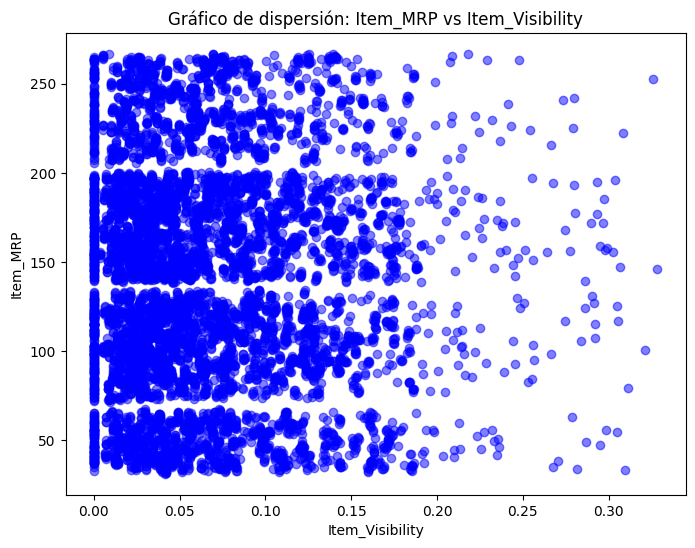

In [383]:
plt.figure(figsize=(8, 6))  # Tamaño del gráfico (ancho, alto)

sp_df_sorted = sp_df.sort_values(by=['Item_Visibility', 'Item_MRP'])

plt.scatter(sp_df_sorted['Item_Visibility'], sp_df_sorted['Item_MRP'], c='blue', alpha=0.5)  # Graficar 'Item_Visibility' vs 'Item_MRP'
#plt.yticks(sp_df.index,sp_df['Item_MRP'] )  # Etiquetas en el eje y

plt.locator_params(nbins=10)


plt.xlabel('Item_Visibility')  # Etiqueta del eje x
plt.ylabel('Item_MRP')  # Etiqueta del eje y
plt.title('Gráfico de dispersión: Item_MRP vs Item_Visibility')  # Título del gráfico
plt.show()

Interpretación:
* Para los productos con precio menor a 100 USD la visibilidad de los items no es un factor determinante. Esto puede descartar cualquier publicidad que se realice a determinado producto ya que su precio en el mercado no se va a modificar conforme aumente su visibilidad.

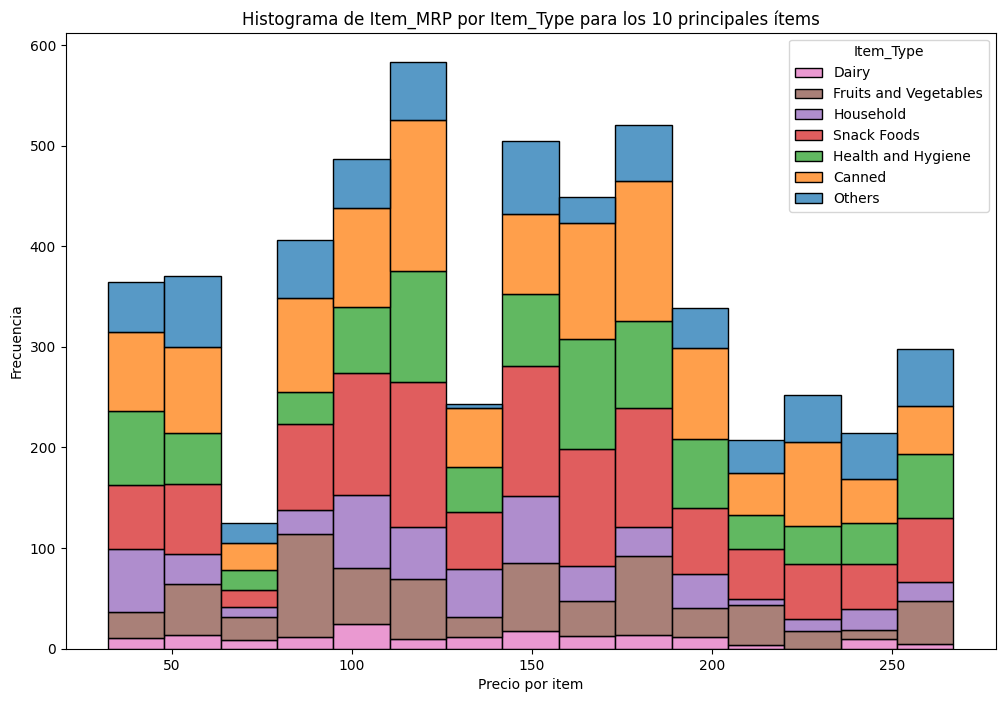

In [384]:
filtered_df = sp_df[sp_df['Item_Type'].isin(top_10_items.index.get_level_values('Item_Type'))]

# Paso 2: Crear el histograma
plt.figure(figsize=(12, 8))
sns.histplot(data=filtered_df, x='Item_MRP', hue='Item_Type', multiple='stack', bins=15)
plt.title('Histograma de Item_MRP por Item_Type para los 10 principales ítems')
plt.xlabel('Precio por item')
plt.ylabel('Frecuencia')
item_type_labels = filtered_df['Item_Type'].unique()

# Establecer las etiquetas en la leyenda
plt.legend(title='Item_Type', labels=item_type_labels)
plt.show()



iNTERPRETACION:

Se observa que gran parte de los precios de los productos se encuentra en 3 franjas importantes: debajo de 70 USD, y en el rango de precios de 80 a 125 USD, y de 140 a 190 USD.

De estos 3, tenemos destaca el segmento de precios que rodean el valor de 100 USD, de forma general para las 10 categorías de productos más vendidos.

Esta información sería muy interesante para poder aplicar una estrategia de precios, junto con promociones o descuentos por el area de marketing, de forma que los productos recaigan en ese margen, logrando aumentar las ventas.

In [385]:
sp_df_precio = sp_df[(sp_df['Item_MRP'] >= 80) & (sp_df['Item_MRP'] <= 100)]
sp_df_precio

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Cantidades_vendidas
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,Small,Tier 2,Supermarket Type1,1076.5986,11.102091
31,NCS17,18.600,Low Fat,0.080829,Health and Hygiene,96.4436,OUT018,2009,Medium,Tier 3,Supermarket Type2,2741.7644,28.428682
33,FDO23,17.850,Low Fat,0.000000,Breads,93.1436,OUT045,2002,Small,Tier 2,Supermarket Type1,2174.5028,23.345703
39,FDB34,15.250,Low Fat,0.026481,Snack Foods,87.6198,OUT027,1985,Medium,Tier 3,Supermarket Type3,2180.4950,24.885871
61,FDV27,7.970,Regular,0.040071,Meat,87.3514,OUT045,2002,Small,Tier 2,Supermarket Type1,1062.6168,12.164851
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8476,NCO41,12.500,Low Fat,0.018887,Health and Hygiene,98.8384,OUT045,2002,Small,Tier 2,Supermarket Type1,1280.9992,12.960542
8479,FDL10,8.395,Low Fat,0.039554,Snack Foods,99.1042,OUT049,1999,Medium,Tier 1,Supermarket Type1,2579.3092,26.026235
8489,FDV13,17.350,Regular,0.027723,Canned,89.6856,OUT018,2009,Medium,Tier 3,Supermarket Type2,2109.2544,23.518317
8513,FDH31,12.000,Regular,0.020407,Meat,99.9042,OUT035,2004,Small,Tier 2,Supermarket Type1,595.2252,5.957960


## Visualizaciones de Analisis explicativo de Datos

In [386]:
sp_df['Outlet_Establishment_Year'] = sp_df['Outlet_Establishment_Year'].astype(str).apply(lambda x: x.split('.')[0])

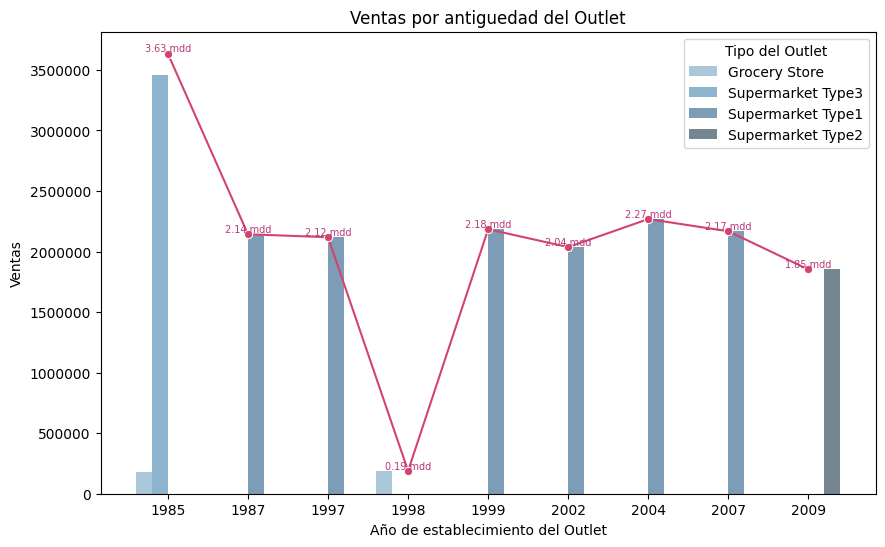

In [387]:
ventas_por_ano_tipo = sp_df.groupby(['Outlet_Establishment_Year', 'Outlet_Type'])['Item_Outlet_Sales'].sum().reset_index()

ventas_por_ano = ventas_por_ano_tipo.groupby('Outlet_Establishment_Year')['Item_Outlet_Sales'].sum().reset_index()

plt.figure(figsize=(10, 6))

sns.barplot(data=ventas_por_ano_tipo, x='Outlet_Establishment_Year', y='Item_Outlet_Sales', hue='Outlet_Type', palette='Blues_d', alpha=0.7)

lineplot = sns.lineplot(data=ventas_por_ano, x='Outlet_Establishment_Year', y='Item_Outlet_Sales', marker='o', color='#d3436e')

for index, row in ventas_por_ano.iterrows():
    ventas_mdd = row['Item_Outlet_Sales'] / 1000000
    lineplot.text(row['Outlet_Establishment_Year'], row['Item_Outlet_Sales'], '{:.2f} mdd'.format(ventas_mdd), size=7, color='#b73779', ha='center', va='bottom')

plt.xlabel('Año de establecimiento del Outlet')
plt.ylabel('Ventas')
plt.title('Ventas por antiguedad del Outlet')
plt.legend(title='Tipo del Outlet')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
plt.show()

Interpretación:

Las tiendas que se establecieron en el año de 1985 son las que representan la mayor cantidad de ventas, lo que significa que podría haber construido una base de clientes leales y una reputación sólida a lo largo de los años.

Otro factor a ser analizado es que las tiendas establecidas en 1985 se trata de tiendas del tipo "Supermarket Type 3". Por tanto una buena estrategia seria generar tiendas más tiendas de dicho tipo, ya sea tomando como base la estrategia de marketing o su zona geográfica.

In [388]:
sp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   object 
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
 12  Cantidades_vendidas        8523 non-null   float64
dtypes: float64(5), object(8)
memory usage: 865.7+ KB

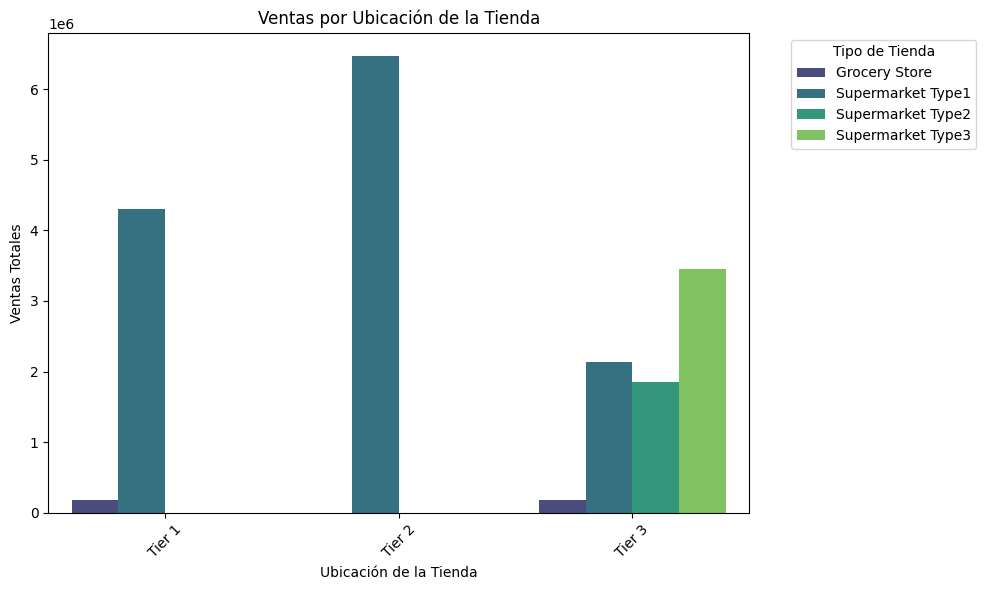

In [389]:
df_ubicacion = sp_df.groupby(['Outlet_Location_Type', 'Outlet_Type'])['Item_Outlet_Sales'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=df_ubicacion, x='Outlet_Location_Type', y='Item_Outlet_Sales', hue='Outlet_Type', dodge=True, palette='viridis')

plt.title('Ventas por Ubicación de la Tienda')
plt.xlabel('Ubicación de la Tienda')
plt.ylabel('Ventas Totales')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Tienda', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()



Interpretación:

Tanto las tiendas ubicadas en el Tier 1 como el Tier 2 generan mayor cantidad de ventas, esto significa que estos lugares son una posición estratégica para crear nuevas tiendas. Sin embargo, en el  grafico analizaremos que productos son vendidos en cada una de las tiendas.

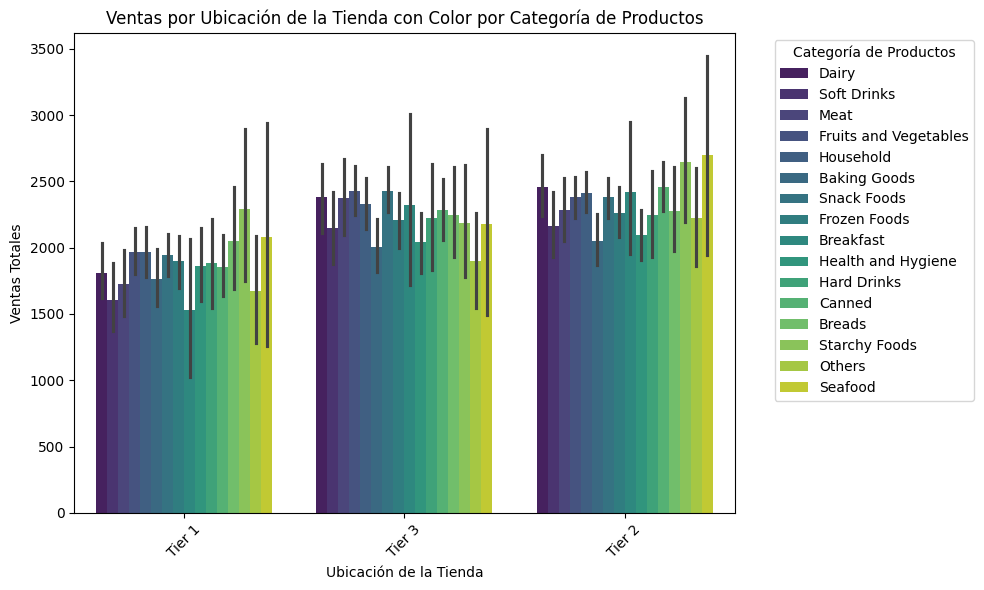

In [390]:
plt.figure(figsize=(10, 6))
sns.barplot(data=sp_df, x='Outlet_Location_Type', y='Item_Outlet_Sales', hue='Item_Type', palette='viridis')
plt.title('Ventas por Ubicación de la Tienda con Color por Categoría de Productos')
plt.xlabel('Ubicación de la Tienda')
plt.ylabel('Ventas Totales')
plt.xticks(rotation=45)
plt.legend(title='Categoría de Productos', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()



Interpretación:

Observamos que tanto Tier 2 como Tier 3 tienen como productos principal los al tipo Seafood, y en un segundo lugar destaca Starchy Foods y Breakfast respectivamente. Este patron de tener a Seafood como uno de los productos mas vendidos tambien se repite en Tier 1, aunque alli en cambio se destaca los productos tipos Bread. Esta combinación de preferencias de productos por ubicación es ideal para identificar patrones de consumo y de comportamiento del consumidor.

# Configuracion X , Y

In [391]:
sp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   object 
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
 12  Cantidades_vendidas        8523 non-null   float64
dtypes: float64(5), object(8)
memory usage: 865.7+ KB

Nuestra target sera Item_Outlet_Sales, para eso vamos a verificar sus valores.

In [392]:
sp_df['Item_Outlet_Sales'].unique()

array([3735.138 ,  443.4228, 2097.27  , ..., 7182.6504, 3608.636 ,
       2778.3834])

In [393]:
sp_df['Item_Outlet_Sales'].isna().sum()

0

In [394]:
sp_df['Item_Outlet_Sales'].describe()

count     8523.000000
mean      2181.288914
std       1706.499616
min         33.290000
25%        834.247400
50%       1794.331000
75%       3101.296400
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64

Todo esta en orden con nuestra target, procedemos a definix X y y

In [395]:
X = sp_df.drop(['Item_Outlet_Sales'], axis=1)
y = sp_df['Item_Outlet_Sales']

In [396]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   object 
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Cantidades_vendidas        8523 non-null   float64
dtypes: float64(4), object(8)
memory usage: 799.2+ KB


In [397]:
X['Item_Identifier'].unique()

array(['FDA15', 'DRC01', 'FDN15', ..., 'NCF55', 'NCW30', 'NCW05'],
      dtype=object)

In [398]:
X['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [399]:
X['Item_Type'].unique()

array(['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables',
       'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods',
       'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned',
       'Breads', 'Starchy Foods', 'Others', 'Seafood'], dtype=object)

In [400]:
X['Outlet_Identifier'].unique()

array(['OUT049', 'OUT018', 'OUT010', 'OUT013', 'OUT027', 'OUT045',
       'OUT017', 'OUT046', 'OUT035', 'OUT019'], dtype=object)

In [401]:
X['Outlet_Establishment_Year'].unique()

array(['1999', '2009', '1998', '1987', '1985', '2002', '2007', '1997',
       '2004'], dtype=object)

In [402]:
X['Outlet_Size'].unique()

array(['Medium', 'Small', 'High'], dtype=object)

In [403]:
X['Outlet_Location_Type'].unique()

array(['Tier 1', 'Tier 3', 'Tier 2'], dtype=object)

In [404]:
X['Outlet_Type'].unique()

array(['Supermarket Type1', 'Supermarket Type2', 'Grocery Store',
       'Supermarket Type3'], dtype=object)

Tenemos:

* 7 caracteristicas categoricas, que segun la descripcion establecida tomaremos como nominales:
   * Item_Identifier, Item_Fat_Content, Item_Type, Outlet_Identifier, Outlet_Size,  Outlet_Location_Type, Outlet_Type

En el caso de Outlet_Establishment_Year  es un object porque representa el año, y para un analisis seria mas interesante la antiguedad. Por ello se procedera a modificar la columna:

In [405]:
X['Outlet_Establishment_Year'] = pd.to_numeric(X['Outlet_Establishment_Year'])
X['Antiguedad'] = 2024 - X['Outlet_Establishment_Year']
X = X.drop(columns=['Outlet_Establishment_Year'])

In [406]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Item_Identifier       8523 non-null   object 
 1   Item_Weight           8523 non-null   float64
 2   Item_Fat_Content      8523 non-null   object 
 3   Item_Visibility       8523 non-null   float64
 4   Item_Type             8523 non-null   object 
 5   Item_MRP              8523 non-null   float64
 6   Outlet_Identifier     8523 non-null   object 
 7   Outlet_Size           8523 non-null   object 
 8   Outlet_Location_Type  8523 non-null   object 
 9   Outlet_Type           8523 non-null   object 
 10  Cantidades_vendidas   8523 non-null   float64
 11  Antiguedad            8523 non-null   int64  
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Por tanto ahora nuestro dataframe solo tiene variables numericas y categoricas nominales, procederemos a transformar.

# Preprocesamiento

Vamos a escalar los datos de nuestra X

In [407]:
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

one_hot_encoder = OneHotEncoder()
standard_scaler = StandardScaler()

imputer_num = SimpleImputer(strategy="mean")
imputer_cat = SimpleImputer(strategy="most_frequent")

Creo mis pipelines

In [408]:
col_transformer = make_column_transformer((make_pipeline(imputer_num,standard_scaler), num_selector),
                                          (make_pipeline(imputer_cat,one_hot_encoder), cat_selector),
                        remainder = 'passthrough')

col_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f481f4894e0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f4868b24190>)])

In [409]:
col_transformer.fit(X)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f481f4894e0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f4868b24190>)])

In [411]:
aux=col_transformer.transform(X)
aux_array = aux.toarray()
X_procesado=pd.DataFrame(aux_array,columns=col_transformer.get_feature_names_out())
X_procesado.info()
X_procesado

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Columns: 1605 entries, pipeline-1__Item_Weight to pipeline-2__Outlet_Type_Supermarket Type3
dtypes: float64(1605)
memory usage: 104.4 MB


,pipeline-1__Item_Weight,pipeline-1__Item_Visibility,pipeline-1__Item_MRP,pipeline-1__Cantidades_vendidas,pipeline-1__Antiguedad,pipeline-2__Item_Identifier_DRA12,pipeline-2__Item_Identifier_DRA24,pipeline-2__Item_Identifier_DRA59,pipeline-2__Item_Identifier_DRB01,pipeline-2__Item_Identifier_DRB13,...,pipeline-2__Outlet_Size_High,pipeline-2__Outlet_Size_Medium,pipeline-2__Outlet_Size_Small,pipeline-2__Outlet_Location_Type_Tier 1,pipeline-2__Outlet_Location_Type_Tier 2,pipeline-2__Outlet_Location_Type_Tier 3,pipeline-2__Outlet_Type_Grocery Store,pipeline-2__Outlet_Type_Supermarket Type1,pipeline-2__Outlet_Type_Supermarket Type2,pipeline-2__Outlet_Type_Supermarket Type3
0,-0.769512,-0.970732,1.747454,-0.051536,-0.139541,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-1.497170,-0.908111,-1.489023,-0.678759,-1.334103,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.995811,-0.956917,0.010040,-0.067051,-0.139541,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.361793,-1.281758,0.660050,-1.240598,-0.020085,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,-0.849167,-1.281758,-1.399220,0.330956,1.293934,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,-1.293727,-0.181193,1.180783,-0.269162,1.293934,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
8519,-0.967573,-0.371154,-0.527301,-1.125649,-0.497909,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
8520,-0.489644,-0.599784,-0.897208,-0.153309,-0.736822,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
8521,-1.219454,1.532880,-0.607977,0.268665,-1.334103,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


En este caso por la cantidad de informacion que contiene (1605 columnas), se uso toarray( )

# Aplicando el modelo de regresion Random Forest Regression

Divido en test de entrenamiento y prueba

In [416]:
X_train, X_test, y_train, y_test = train_test_split(X_procesado, y, test_size=0.3, random_state=42)

Defino los parametros del modelo

In [417]:
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

In [418]:
random_forest.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Calculo mi y predicho

In [419]:
y_pred = random_forest.predict(X_test)

# Reviso las metricas de la primera version de mi modelo

In [420]:
print('Accuracy test:', random_forest.score(X_test, y_test))
print('Accuracy train:', random_forest.score(X_train, y_train))

Accuracy train: 0.999790990216093
Accuracy test: 0.9986545662548859


El modelo tiene un muy buen grado de ajuste con mi data  y casi nula diferencia entre los mismos, por tanto tenemos revisar las otras metricas

In [421]:
mse = mean_squared_error(y_test, y_pred)
print("Error Cuadrático Medio (MSE):", mse)

r2 = r2_score(y_test, y_pred)
print("Coeficiente de Determinación (R^2):", r2)

mae = mean_absolute_error(y_test, y_pred)
print("Error Absoluto Medio (MAE):", mae)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Raíz del Error Cuadrático Medio (RMSE):", rmse)

Error Cuadrático Medio (MSE): 3768.551211558243
Coeficiente de Determinación (R^2): 0.9986545662548859
Error Absoluto Medio (MAE): 22.790888616347264
Raíz del Error Cuadrático Medio (RMSE): 61.388526709461296


Interpretación:

* El modelo de Random Forest tiene un rendimiento muy bueno en este conjunto de datos. Las métricas de evaluación, como el coeficiente de determinación (R^2) cercano a 1 y el bajo error cuadrático medio (MSE), indican que el modelo es capaz de predecir con precisión las ventas de los productos.

* El coeficiente de determinación (R^2) de 0.9987 indica que el 99.87% de la variabilidad en las ventas de los productos es explicada por el modelo. Esto sugiere que el modelo captura efectivamente la relación entre las características de los productos y sus ventas.

* El error absoluto medio (MAE) de aproximadamente 22.79 unidades indica que, en promedio, las predicciones del modelo están a una distancia de aproximadamente 22.79 unidades del valor real de las ventas de los productos. Este error parece ser razonablemente bajo, considerando la naturaleza de los datos.

* El valor de la raíz del error cuadrático medio (RMSE) de aproximadamente 61.39 unidades indica que las predicciones del modelo están bastante cerca de los valores reales de las ventas de los productos, con una dispersión moderada alrededor de las predicciones.


# Uso de grid search para mejorar hiperparametros

In [436]:
n_estimators_values = [100, 200, 300, 400, 500]

In [437]:
random_forest1 = RandomForestRegressor(random_state=42)

In [438]:
grid_search = GridSearchCV(estimator=random_forest1, param_grid={'n_estimators': n_estimators_values}, cv=3, scoring='neg_mean_squared_error')

In [439]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
             param_grid={'n_estimators': [100, 200, 300, 400, 500]},
             scoring='neg_mean_squared_error')

In [440]:
print("Mejores hiperparámetros:", grid_search.best_params_)

Mejores hiperparámetros: {'n_estimators': 400}


Usemos el mejor parametro para nuevamente ejecutar nuestro modelo

In [441]:
best_model = grid_search.best_estimator_

In [443]:
y_pred_b = best_model.predict(X_test)

# Reviso las metricas de la segunda version de mi modelo

In [448]:
print('Accuracy train modelo mejorado:', best_model.score(X_train, y_train))
print('Accuracy test modelo mejorado:', best_model.score(X_test, y_test))

Accuracy train modelo mejorado: 0.9998214995427513
Accuracy test modelo mejorado: 0.9987215284819961


In [449]:
print('Accuracy test primer modelo:', random_forest.score(X_test, y_test))
print('Accuracy train primer modelo:', random_forest.score(X_train, y_train))

Accuracy test primer modelo: 0.9986545662548859
Accuracy train primer modelo: 0.999790990216093


Ambos modelos muestran una excelente precisión tanto en el conjunto de entrenamiento como en el conjunto de prueba. Sin embargo, el modelo mejorado parece tener un ligero incremento en la precisión en comparación con el primer modelo en ambos conjuntos.

In [446]:
mseb = mean_squared_error(y_test, y_pred_b)
print("Error Cuadrático Medio (MSE):", mseb)

r2b = r2_score(y_test, y_pred_b)
print("Coeficiente de Determinación (R^2):", r2b)

maeb = mean_absolute_error(y_test, y_pred_b)
print("Error Absoluto Medio (MAE):", maeb)

rmseb = mean_squared_error(y_test, y_pred_b, squared=False)
print("Raíz del Error Cuadrático Medio (RMSE):", rmseb)

Error Cuadrático Medio (MSE): 3580.9904468448904
Coeficiente de Determinación (R^2): 0.9987215284819961
Error Absoluto Medio (MAE): 21.844481386781457
Raíz del Error Cuadrático Medio (RMSE): 59.84137738091337


Revisando los errores, el mejor modelo tiene un buen ajuste global según el coeficiente de determinación (R^2), pero muestra un error medio relativamente alto (MSE) y errores de predicción moderadamente grandes (RMSE y MAE). Es posible que se necesiten ajustes adicionales para mejorar aún más la precisión del modelo.

# Revision asociacion de cada caracteristica - prediccion de ventas

Generamos una lista de las variables mas importantes para predecir las ventas de productos

In [427]:
importances = random_forest.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_procesado.columns, 'Importance': importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                                Feature  Importance
3       pipeline-1__Cantidades_vendidas    0.610055
2                  pipeline-1__Item_MRP    0.388528
1           pipeline-1__Item_Visibility    0.000346
0               pipeline-1__Item_Weight    0.000273
1315  pipeline-2__Item_Identifier_NCE42    0.000062
...                                 ...         ...
256   pipeline-2__Item_Identifier_FDC23    0.000000
258   pipeline-2__Item_Identifier_FDC28    0.000000
805   pipeline-2__Item_Identifier_FDQ33    0.000000
1181  pipeline-2__Item_Identifier_FDY12    0.000000
691   pipeline-2__Item_Identifier_FDN52    0.000000

[1605 rows x 2 columns]


In [426]:
sp_df['Item_MRP'].unique()

array([249.8092,  48.2692, 141.618 , ...,  57.5904, 214.5218,  75.467 ])

Segun se observa, que las cantidades vendidas es la característica más importante para predecir las ventas de productos, seguida por el precio minorista maximo (en lista) del producto.

Esto indica que el precio de los productos juega un papel importante en las ventas, siendo una buena decisión estratégica ajustar los precios de los productos.